In [1]:
import pantas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.read_csv('metadata.csv').drop('SNo', axis=1)

,Column name,Details
0,Status,credit status
1,Seniority,job seniority (years)
2,Home,type of home ownership
3,Time,time of requested loan
4,Age,client's age
5,Marital,marital status
6,Records,existance of records
7,Job,type of job
8,Expenses,amount of expenses
9,Income,amount of income


In [3]:
df_all = pd.read_csv('CreditScoring.csv')

In [4]:
df_all.columns = df_all.columns.str.lower()

In [5]:
df = df_all.copy()

In [6]:
categorical_cols = ['status', 'home', 'marital', 'records', 'job']

In [7]:
for col in categorical_cols:
    print(col, df[col].unique())
    print()

status [1 2 0]

home [1 2 5 3 6 4 0]

marital [2 3 1 4 5 0]

records [1 2]

job [3 1 2 0 4]



In [8]:
col_maps = {
    "status": {
        1: "ok",
        2: "default",
        0: "unk"
    },
    "home": {
        1: "rent",
        2: "owner", 
        3: "private", 
        4: "ignore", 
        5: "parents", 
        6: "other",
        0: "unk"
    },
    "marital": {
        1: "single",
        2: "married",
        3: "widow",
        4: "separated",
        5: "divorced",
        0: "unk"
    },
    "records": {
        1: "no",
        2: "yes"
    },
    "job": {
        1: "fixed",
        2: "partime",
        3: "freelance",
        4: "others",
        0: "unk"
    }
}

for col in col_maps.keys():
    df[col] = df[col].map(col_maps[col])

In [9]:
for col in ['income', 'assets', 'debt']:
    df[col] = df[col].replace(to_replace=99999999.0, value=0)

In [10]:
df.isna().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [30]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


### EDA and feature extraction

In [28]:
numerical_cols = ["seniority","time", "age", "expenses", "income", "assets", "debt", "amount", "price"]
categorical_cols = ["home", "marital", "records", "job"]

#### Correlation coefficient

In [180]:
corrs = df[numerical_cols].corrwith((df.status == "default").astype(int))

In [182]:
corrs.sort_values()

seniority   -0.260414
income      -0.214099
assets      -0.097824
age         -0.095129
debt         0.010049
price        0.010644
expenses     0.028999
time         0.100483
amount       0.154390
dtype: float64

##### AUC score

In [142]:
from sklearn.metrics import roc_auc_score, roc_curve

In [178]:
flipped = []
aucs = []
for col in numerical_cols:
    auc_score = roc_auc_score((df.status == "default").astype(int), df[col])
    if auc_score < 0.5:
        flipped.append(col)
    aucs.append(auc_score if auc_score>0.5 else 1-auc_score)
aucdf = pd.DataFrame()
aucdf["auc"] = aucs
aucdf.index = numerical_cols
aucdf.sort_values("auc", ascending=False)

,auc
seniority,0.696710
income,0.667437
assets,0.633119
amount,0.594475
age,0.557925
time,0.553540
debt,0.507281
expenses,0.502307
price,0.500324


D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

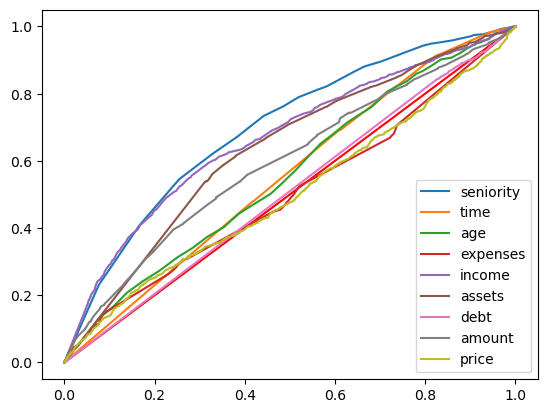

In [166]:
sns.lineplot(x=[0,1], y=[0, 1], color="red")
for col in numerical_cols:
    fpr, tpr, ts = roc_curve((df.status == "default").astype(int), -df[col] if col in flipped else df[col])
    sns.lineplot(x=fpr, y=tpr, label=col)

#### Mutual information

##### Positive rate

In [106]:
from IPython.display import display

In [129]:
gr = (df.status == "default").mean()
for col in categorical_cols:
    print(col)
    rates = []
    for cat in df[col].unique().tolist():
        catr = (df[df[col]==cat].status == "default").mean()
        rates.append(gr - catr)
    rdf = pd.DataFrame(columns=["Rate"], index=df[col].unique().tolist())
    rdf["Rate"] = rates
    display(rdf.sort_values("Rate"))
    print()

home


,Rate
unk,-0.385185
other,-0.176199
ignore,-0.168519
rent,-0.117285
private,-0.058599
parents,-0.016092
owner,0.096384



marital


,Rate
separated,-0.210826
divorced,-0.086940
single,-0.053897
widow,-0.002101
married,0.025696
unk,0.281481



records


,Rate
yes,-0.273499
no,0.057418



job


,Rate
unk,-0.718519
partime,-0.318076
others,-0.116179
freelance,-0.043714
fixed,0.074782


##### Risk rate

In [127]:
gr = (df.status == "default").mean()
for col in categorical_cols:
    print(col)
    ristrs = []
    for cat in df[col].unique().tolist():
        catr = (df[df[col]==cat].status == "default").mean()
        ristrs.append(catr/gr)
    rdf = pd.DataFrame(columns=["Risk"], index=df[col].unique().tolist())
    rdf["Risk"] = ristrs
    display(rdf.sort_values("Risk", ascending=False))
    print()

home


,Risk
unk,2.368421
other,1.625969
ignore,1.598684
rent,1.416671
private,1.208182
parents,1.057169
owner,0.657582



marital


,Risk
separated,1.748988
divorced,1.308864
single,1.191476
widow,1.007463
married,0.908711
unk,0.000000



records


,Risk
yes,1.971642
no,0.796013



job


,Risk
unk,3.552632
partime,2.130007
others,1.412742
freelance,1.155299
fixed,0.734329


##### Mutual info

In [66]:
from sklearn.metrics import mutual_info_score

In [92]:
for col in categorical_cols:
    print("%8s -> %4.3f" % (col, mutual_info_score(df[col], df.status)))

    home -> 0.026
 marital -> 0.006
 records -> 0.035
     job -> 0.034


### Data prep

In [191]:
from sklearn.model_selection import train_test_split

In [215]:
train_full ,test = train_test_split(df, test_size=.2)
train, val = train_test_split(train_full, test_size=.25)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [217]:
X_train_df = train[categorical_cols + numerical_cols]
X_val_df = val[categorical_cols + numerical_cols]
X_test_df = test[categorical_cols + numerical_cols]

In [219]:
y_train = (train.status == "default").astype(int)
y_val = (val.status == "default").astype(int)
y_test = (test.status == "default").astype(int)

In [221]:
X_train_df

,home,marital,records,job,seniority,time,age,expenses,income,assets,debt,amount,price
0,other,single,no,fixed,2,60,22,35,58,12000,0,1450,1600
1,owner,divorced,no,fixed,1,48,42,35,210,6500,1500,1650,1679
2,rent,married,no,fixed,19,60,41,88,125,0,0,1450,1564
3,owner,married,no,freelance,6,48,39,75,0,6000,0,1000,1177
4,owner,married,yes,fixed,14,60,37,75,60,2500,0,1500,1648
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,owner,married,no,fixed,14,48,43,45,200,9000,0,600,1025
2669,owner,married,no,fixed,12,48,46,60,130,6000,0,1480,1883
2670,rent,married,no,fixed,20,60,61,81,211,0,0,1475,1475
2671,owner,married,no,freelance,14,12,37,90,500,4000,0,500,1338


In [207]:
from sklearn.feature_extraction import DictVectorizer

In [223]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_df.to_dict(orient='records'))

In [225]:
X_val = dv.transform(X_val_df.to_dict(orient='records'))
X_test = dv.transform(X_test_df.to_dict(orient='records'))

### Random forest more features

In [186]:
from sklearn.ensemble import RandomForestClassifier

In [227]:
rf_final = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70, random_state=42, n_jobs=10)
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70,
                       n_jobs=10, random_state=42)

In [231]:
roc_auc_score(y_val, rf_final.predict_proba(X_val)[:,1])

0.8541215082601614

#### Tune  max_features and bootstrap

#####  max_features

In [236]:
from tqdm.auto import tqdm

In [260]:
def for_max_features(max_features_list):
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 10)]
    for  max_features in tqdm(max_features_list, total=len(max_features_list)):
        auc_scores = []
        for n in tqdm(range(10, 201, 10), total=len(range(10, 201, 10))):
            rf = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=n, random_state=42, n_jobs=10, max_features=max_features)
            rf.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
        aucdf[max_features] = auc_scores

    return aucdf

In [272]:
def show_max_features_curves(aucdf, max_features_list):
    for max_features in max_features_list:
        sns.lineplot(aucdf, x="n_estimators", y=max_features, label=max_features)
    plt.show()

In [266]:
aucdf = for_max_features([0.1, 0.3, .5, 0.7, 1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

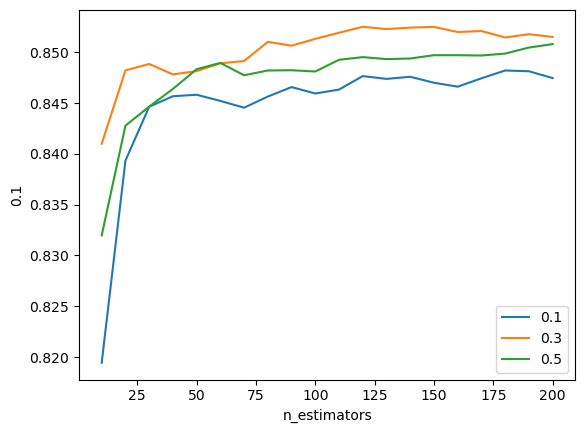

In [276]:
show_max_features_curves(aucdf, [0.1, 0.3, .5])

In [278]:
aucdf = for_max_features([0.2, 0.3, 0.4, 0.5])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

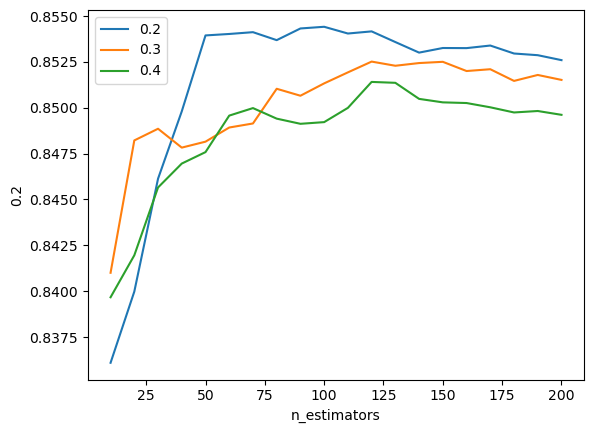

In [282]:
show_max_features_curves(aucdf, [0.2, 0.3, 0.4])

In [284]:
aucdf = for_max_features([0.15, 0.2, 0.25])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

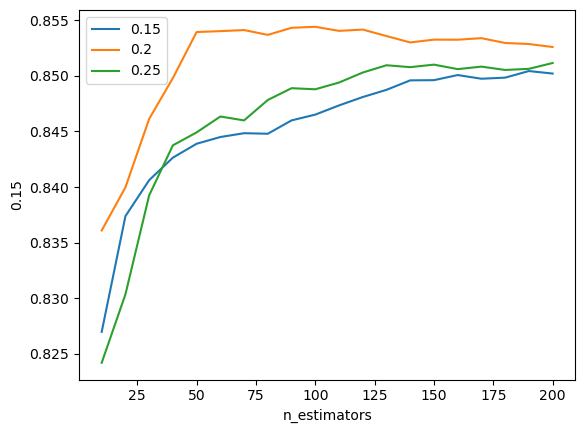

In [286]:
show_max_features_curves(aucdf, [0.15, 0.2, 0.25])

In [288]:
final_max_features = 0.2

##### bootstrap

In [310]:
def for_bootstrap():
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 10)]
    for  bootstrap in tqdm([True, False], total=2):
        auc_scores = []
        for n in tqdm(range(10, 201, 10), total=len(range(10, 201, 10))):
            rf = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=n, random_state=42, n_jobs=10, max_features=0.2, bootstrap=bootstrap)
            rf.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
        aucdf[str(bootstrap)] = auc_scores

    return aucdf

In [312]:
aucdf = for_bootstrap()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

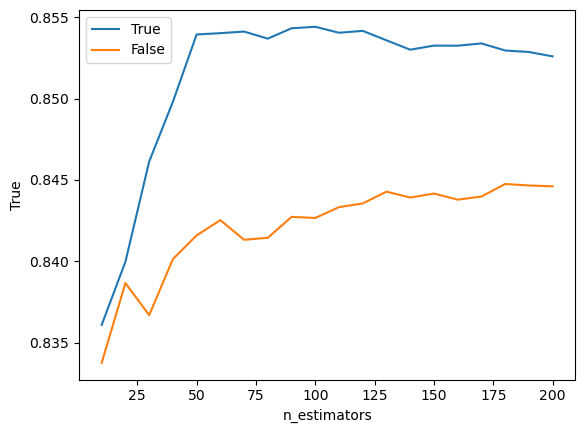

In [314]:
for bootstrap in ["True", "False"]:
    sns.lineplot(aucdf, x="n_estimators", y=bootstrap, label=bootstrap)
plt.show()

In [298]:
final_bootstrap = True

##### n_estimators

In [323]:
aucdf[aucdf["True"] == aucdf["True"].max()]

,n_estimators,True,False
9,100,0.854415,0.842665


In [325]:
final_n_estimators = 100

### Final model

In [330]:
rf_final = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70, random_state=42, n_jobs=10, max_features=0.2, bootstrap=True)
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_leaf=3,
                       n_estimators=70, n_jobs=10, random_state=42)

In [332]:
roc_auc_score(y_val, rf_final.predict_proba(X_val)[:,1]), roc_auc_score(y_test, rf_final.predict_proba(X_test)[:,1])

(0.8541215082601614, 0.8182747469240587)

In [338]:
X_full_train = dv.transform(train_full[numerical_cols+categorical_cols].to_dict(orient='records'))
y_full_train = (train_full.status == "default").astype(int)

In [340]:
rf_final = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=70, random_state=42, n_jobs=10, max_features=0.2, bootstrap=True)
rf_final.fit(X_full_train, y_full_train)

RandomForestClassifier(max_depth=10, max_features=0.2, min_samples_leaf=3,
                       n_estimators=70, n_jobs=10, random_state=42)

In [342]:
roc_auc_score(y_test, rf_final.predict_proba(X_test)[:,1])

0.8259196847857063

### Extremely randomized trees

In [347]:
from sklearn.ensemble import ExtraTreesClassifier

In [351]:
et = ExtraTreesClassifier(n_estimators=200)
et.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=200)

In [357]:
roc_auc_score(y_val, et.predict_proba(X_val)[:,1])

0.7960370819403113

### Parameter tuning

#### max_depth

In [369]:
def show_for_cols_curves(aucdf, cols):
    for col in cols:
        sns.lineplot(aucdf, x="n_estimators", y=col, label=col)
    plt.show()

In [361]:
def for_max_depth(max_depths):
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 10)]
    for  max_depth in tqdm(max_depths, total=len(max_depths)):
        auc_scores = []
        for n in tqdm(range(10, 201, 10), total=len(range(10, 201, 10))):
            et = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n, random_state=42, n_jobs=10)
            et.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, et.predict_proba(X_val)[:,1]))
        aucdf[max_depth] = auc_scores

    return aucdf

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

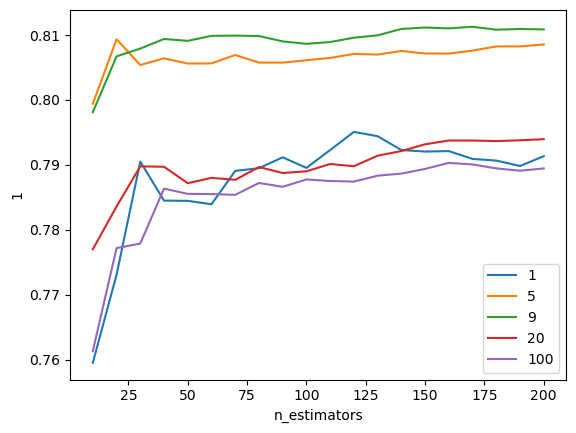

In [379]:
aucdf = for_max_depth([1,5, 9, 20, 100])
show_for_cols_curves(aucdf, [1,5, 9, 20, 100])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

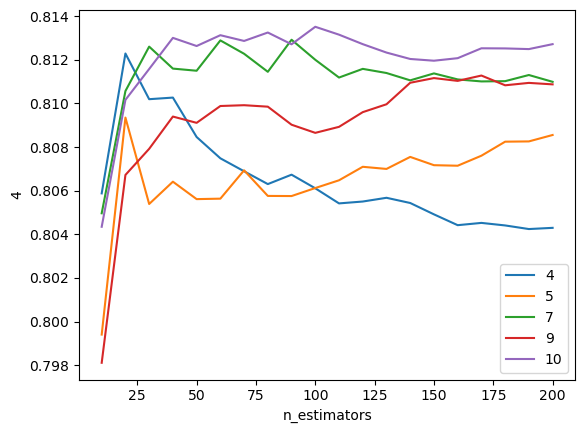

In [380]:
aucdf = for_max_depth([4, 5, 7, 9, 10])
show_for_cols_curves(aucdf, [4, 5, 7, 9, 10])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

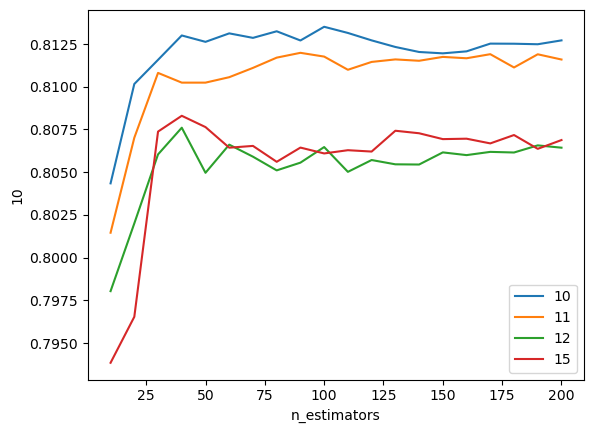

In [383]:
aucdf = for_max_depth([10, 11, 12, 15])
show_for_cols_curves(aucdf, [10, 11, 12, 15])

In [387]:
final_max_depth = 10

#### min_samples_leaf

In [401]:
def for_min_samples_leaf(min_samples_leafs):
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 5)]
    for  min_samples_leaf in tqdm(min_samples_leafs, total=len(min_samples_leafs)):
        auc_scores = []
        for n in tqdm(range(10, 201, 5), total=len(range(10, 201, 5))):
            et = ExtraTreesClassifier(max_depth=10, min_samples_leaf=min_samples_leaf,n_estimators=n, random_state=42, n_jobs=10)
            et.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, et.predict_proba(X_val)[:,1]))
        aucdf[min_samples_leaf] = auc_scores

    return aucdf

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

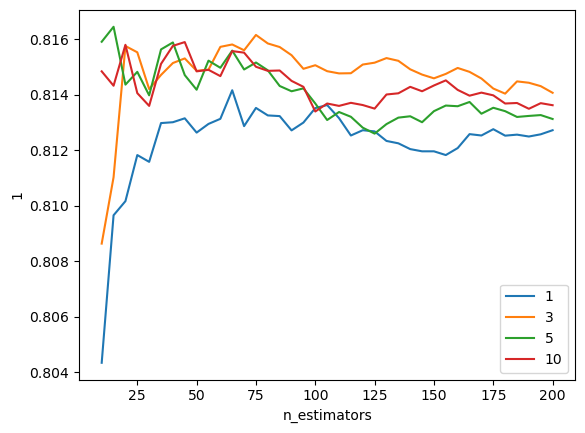

In [403]:
aucdf = for_min_samples_leaf([1,3,5,10])
show_for_cols_curves(aucdf, [1,3,5,10])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

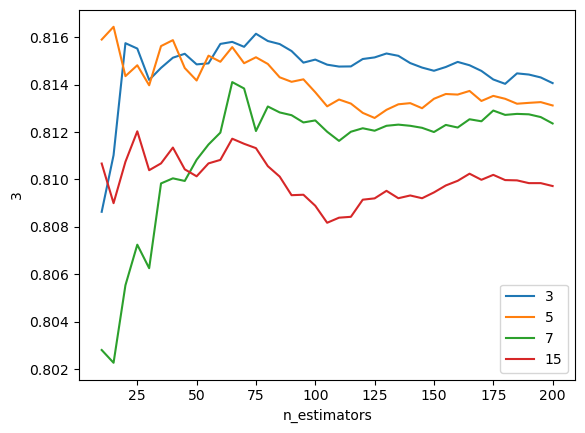

In [405]:
aucdf = for_min_samples_leaf([3,5,7, 15])
show_for_cols_curves(aucdf, [3,5,7,15])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

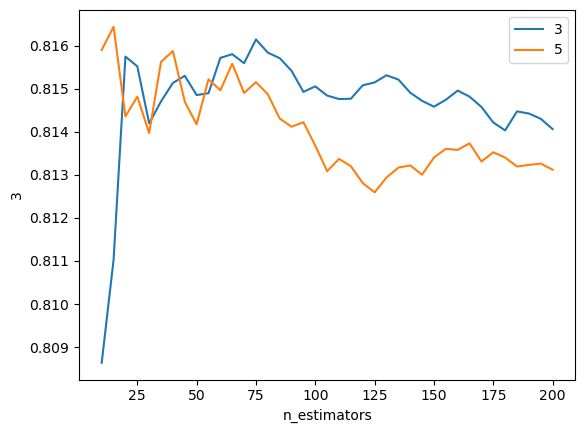

In [407]:
aucdf = for_min_samples_leaf([3,5])
show_for_cols_curves(aucdf, [3,5])

In [411]:
final_min_samples_leaf = 3

#### max_features

In [416]:
def for_min_max_features(max_features):
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 5)]
    for  mfs in tqdm(max_features, total=len(max_features)):
        auc_scores = []
        for n in tqdm(range(10, 201, 5), total=len(range(10, 201, 5))):
            et = ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, max_features=mfs, n_estimators=n, random_state=42, n_jobs=10)
            et.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, et.predict_proba(X_val)[:,1]))
        aucdf[mfs] = auc_scores

    return aucdf

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

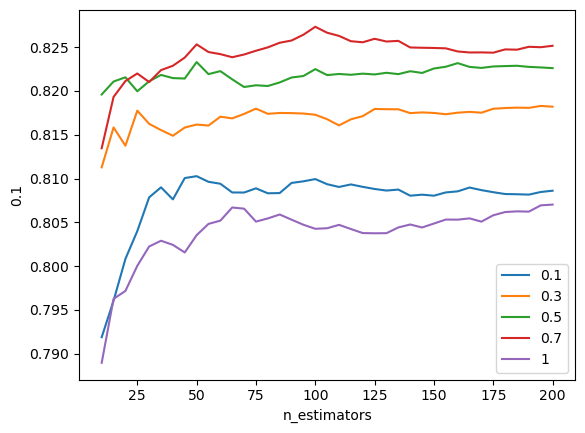

In [418]:
arr = [0.1, 0.3, 0.5, 0.7, 1]
aucdf = for_min_max_features(arr)
show_for_cols_curves(aucdf, arr)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

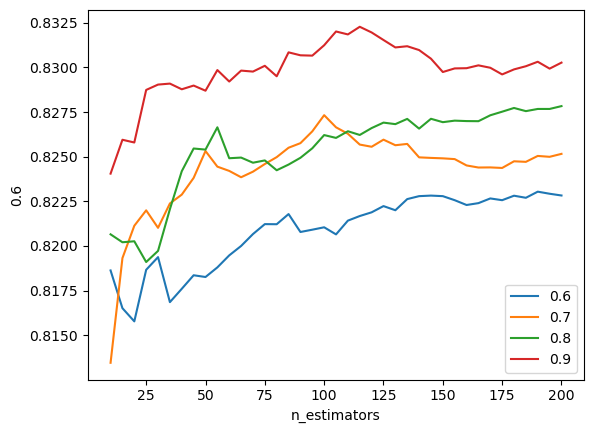

In [420]:
arr = [0.6, 0.7, 0.8, 0.9]
aucdf = for_min_max_features(arr)
show_for_cols_curves(aucdf, arr)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

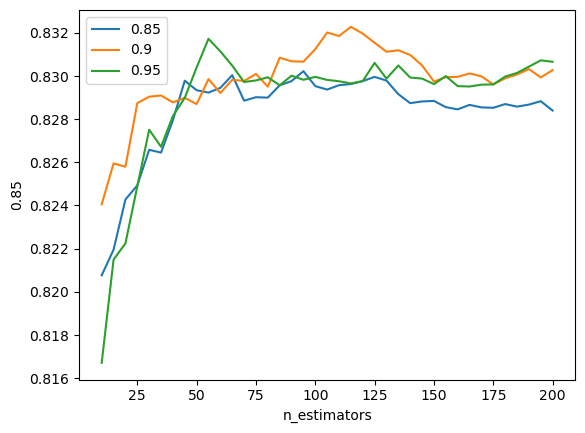

In [422]:
arr = [0.85, 0.9, 0.95]
aucdf = for_min_max_features(arr)
show_for_cols_curves(aucdf, arr)

In [424]:
final_min_max_features = 0.9

In [430]:
def for_bootstrap():
    aucdf = pd.DataFrame()
    aucdf['n_estimators'] = [i for i in range(10, 201, 5)]
    for  bootstrap in tqdm([True, False], total=2):
        auc_scores = []
        for n in tqdm(range(10, 201, 5), total=len(range(10, 201, 5))):
            et = ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, max_features=0.9, bootstrap=bootstrap, n_estimators=n, random_state=42, n_jobs=10)
            et.fit(X_train, y_train)
            auc_scores.append(roc_auc_score(y_val, et.predict_proba(X_val)[:,1]))
        aucdf[str(bootstrap)] = auc_scores

    return aucdf

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

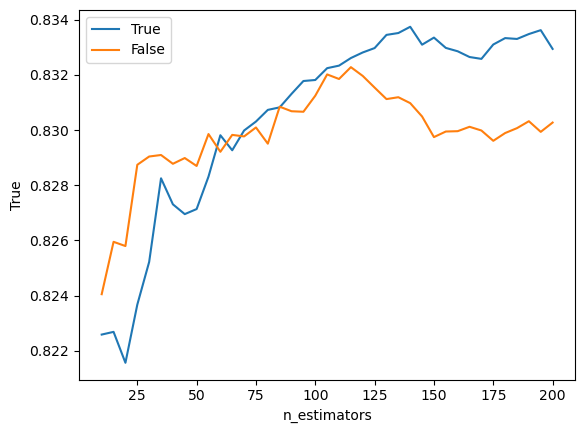

In [432]:
aucdf = for_bootstrap()
show_for_cols_curves(aucdf, ["True", "False"])

In [434]:
final_bootstrap = True

In [436]:
aucdf[aucdf["True"] == aucdf["True"].max()]

,n_estimators,True,False
26,140,0.833744,0.830976


In [440]:
final_n_estimators = 140

### Final model

In [444]:
et = ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, max_features=0.9, bootstrap=True, n_estimators=n, random_state=42, n_jobs=10)
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_depth=10, max_features=0.9,
                     min_samples_leaf=3, n_estimators=200, n_jobs=10,
                     random_state=42)

In [448]:
roc_auc_score(y_val, et.predict_proba(X_val)[:,1]), roc_auc_score(y_test, et.predict_proba(X_test)[:,1])

(0.8329414502124741, 0.8046142218147124)

In [450]:
et_final = ExtraTreesClassifier(max_depth=10, min_samples_leaf=3, max_features=0.9, bootstrap=True, n_estimators=n, random_state=42, n_jobs=10)
et_final.fit(X_full_train, y_full_train)

ExtraTreesClassifier(bootstrap=True, max_depth=10, max_features=0.9,
                     min_samples_leaf=3, n_estimators=200, n_jobs=10,
                     random_state=42)

In [456]:
roc_auc_score(y_test, et_final.predict_proba(X_test)[:,1])

0.8108776190417187

### XGBoost can deal with NAs

In [465]:
train_full.isna().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

### XGBoost other params

In [474]:
import xgboost as xgb

In [628]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)

In [483]:
score_results = {}

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,
    
    'objective': "binary:logistic",
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1
}

model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals_result=score_results)

In [485]:
roc_auc_score(y_val, model.predict(dval))

0.8678802797065776

In [556]:
def show_all_aucs(aucs, vals, ylim=None):
    for val in vals:
        auc_df = aucs[val]
        sns.lineplot(auc_df, x="num_boost_round", y="val_auc", label=val)
    plt.ylim(ylim)
    plt.show()

#### subsample

In [543]:
def for_subsample(subsamples):
    scores = {}
    for subsample in tqdm(subsamples, total=len(subsamples)):
        score_results = {}

        xgb_params = {
            'eta': 0.1,
            'max_depth': 3,
            'min_child_weight': 10,

            'objective': "binary:logistic",
            'eval_metric': 'auc',
            'nthread': 8,
            
            'subsample': subsample,

            'seed': 42,
            'verbosity': 1
        }

        model = xgb.train(params=xgb_params, evals=[(dval, 'val')], dtrain=dtrain, num_boost_round=200, evals_result=score_results, verbose_eval=False)
        
        columns = ['num_boost_round', 'val_auc']
        val_aucs = list(score_results['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(val_aucs) + 1),
                val_aucs
            )), columns=columns)
        scores[subsample] = df_scores
    return scores

In [549]:
arr = [0.1, 0.3, 0.5, 0.7, 1]
aucs = for_subsample(arr)

  0%|          | 0/5 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

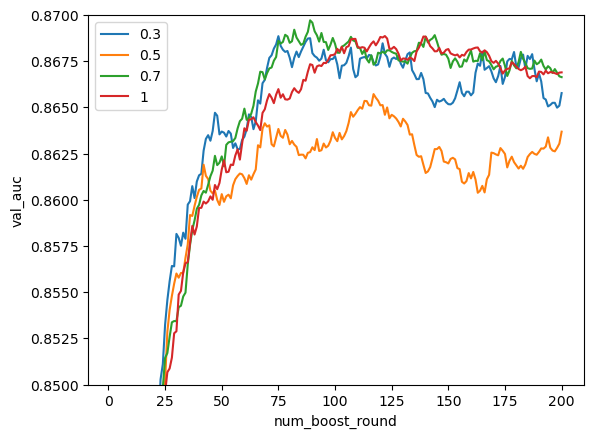

In [558]:
show_all_aucs(aucs, [0.3, 0.5, 0.7, 1], (.85, .87))

In [560]:
arr = [0.6, 0.7, 0.8, 0.9]
aucs = for_subsample(arr)

  0%|          | 0/4 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

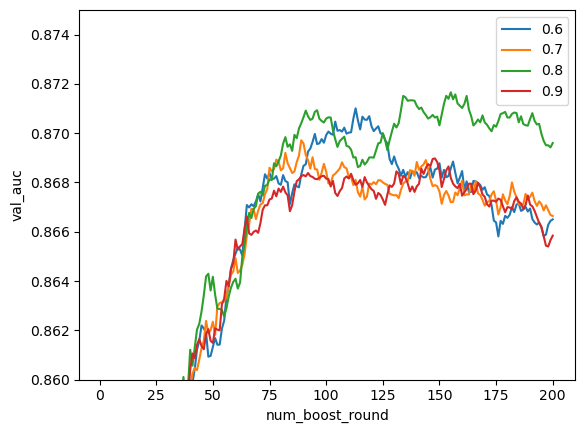

In [566]:
show_all_aucs(aucs, arr, (.86, .875))

In [568]:
arr = [0.75, 0.8, 0.85]
aucs = for_subsample(arr)

  0%|          | 0/3 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

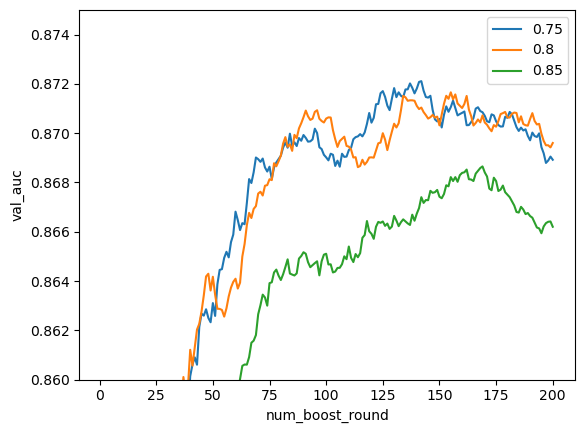

In [570]:
show_all_aucs(aucs, arr, (.86, .875))

In [572]:
final_subsample = 0.75

#### colsample_bytree

In [583]:
def for_colsample_bytree(colsample_bytrees):
    scores = {}
    for colsample_bytree in tqdm(colsample_bytrees, total=len(colsample_bytrees)):
        score_results = {}

        xgb_params = {
            'eta': 0.1,
            'max_depth': 3,
            'min_child_weight': 10,

            'objective': "binary:logistic",
            'eval_metric': 'auc',
            'nthread': 8,
            
            'subsample': 0.75,
            'colsample_bytree': colsample_bytree,

            'seed': 42,
            'verbosity': 1
        }

        model = xgb.train(params=xgb_params, evals=[(dval, 'val')], dtrain=dtrain, num_boost_round=200, evals_result=score_results, verbose_eval=False)
        
        columns = ['num_boost_round', 'val_auc']
        val_aucs = list(score_results['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(val_aucs) + 1),
                val_aucs
            )), columns=columns)
        scores[colsample_bytree] = df_scores
    return scores

In [585]:
arr = [0.1, 0.3, 0.5, 0.7, 1]
aucs = for_colsample_bytree(arr)

  0%|          | 0/5 [00:00<?, ?it/s]

D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Apps\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

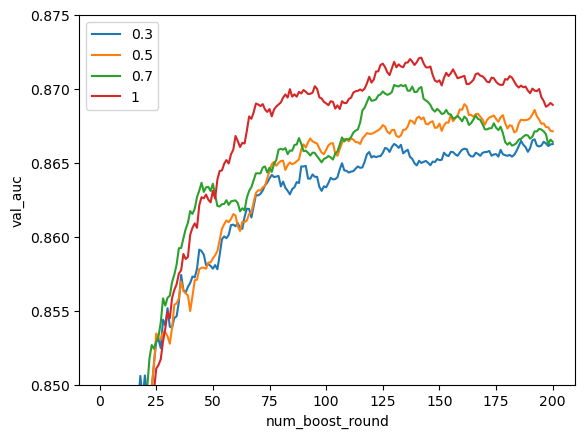

In [591]:
show_all_aucs(aucs, [0.3, 0.5, 0.7, 1], (0.85, .875))

In [593]:
final_colsample_bytree = 1

In [604]:
auc1 = aucs[1]
auc1[auc1['val_auc'] == auc1['val_auc'].max()]

,num_boost_round,val_auc
141,142,0.872111


In [606]:
num_boost_round = 142

### Final

In [608]:
score_results = {}

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': "binary:logistic",
    'eval_metric': 'auc',
    'nthread': 8,

    'subsample': 0.75,
    'colsample_bytree': 1,

    'seed': 42,
    'verbosity': 1
}

model = xgb.train(params=xgb_params, evals=[(dval, 'val')], dtrain=dtrain, num_boost_round=142, evals_result=score_results, verbose_eval=False)

In [630]:
roc_auc_score(y_val, model.predict(dval)), roc_auc_score(y_test, model.predict(dtest))

(0.8721113927771043, 0.8286517898075756)

In [638]:
dfull_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)

In [640]:
score_results = {}

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': "binary:logistic",
    'eval_metric': 'auc',
    'nthread': 8,

    'subsample': 0.75,
    'colsample_bytree': 1,

    'seed': 42,
    'verbosity': 1
}

final_model = xgb.train(params=xgb_params, dtrain=dfull_train, num_boost_round=142, evals_result=score_results, verbose_eval=False)

In [642]:
roc_auc_score(y_test, final_model.predict(dtest))

0.8246868301386496